# Librairies

In [7]:
import glob
from pathlib import Path
import os
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler

from numpy.random import seed
seed(1)


print(keras.__version__)
print(pd.__version__)

2.4.3
1.0.5


# Parameters

In [8]:
#Grid size + response variable 
gridSize=100
provider="Mapbox"
verbose = False
resp="v_CA16_406" #v_CA16_2540:poverty -- v_CA16_406:pop_density per sq km
finalNonLin = "sigmoid" if resp == "v_CA16_2540" else "relu" #final non-linearity: sigmoid to predict [0,1] normalized value vs relu otherwise (since response is non-negative)
idGrid="gridId"
ubNumTotal = 3*10**2 #use this upper bound, otherwise it is impossible to load all images into anarray => should most likey think of some better data pipeline where we load batches of images eachtimeS

In [9]:
rootDir='/home/charles/Projects/NeuralNetPopulation'

In [10]:
#Path to out put figures
figuresOutputPath = Path(rootDir) / "Figures" / provider / str(gridSize )

if not os.path.exists(figuresOutputPath):
    print(f"Creating directory {figuresOutputPath}")
    os.makedirs(figuresOutputPath)
else:
    print(f"Directory {figuresOutputPath} already exists")

Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists


In [11]:
#Path to output tmp models
modelsOutputPath = Path("." ) / ".." / ".." / "Data" / "Models" / provider / str(gridSize )

if not os.path.exists(modelsOutputPath):
    print(f"Creating directory {modelsOutputPath}")
    os.makedirs(modelsOutputPath)
else:
    print(f"Directory {modelsOutputPath} already exists")

Directory ../../Data/Models/Mapbox/100 already exists


In [12]:
#Path to save the history as a csv
historyOutputPath = Path("." ) / ".." /  ".." / "Data" / "History" / provider / str(gridSize )

if not os.path.exists(historyOutputPath):
    print(f"Creating directory {historyOutputPath}")
    os.makedirs(historyOutputPath)
else:
    print(f"Directory {historyOutputPath} already exists")

Directory ../../Data/History/Mapbox/100 already exists


In [13]:
#Path to census shp file
shpFilePath = Path(".") / ".." /  ".." /  "Data" / "GeoData" / "Shp" / "shpCensusMtl.shp"

In [14]:
#Parameters for conv net
lr = 5*10**-4
numEpochs=20 # 
batchSize=2**5 #32

l1Coeff = 0 #10**-3
dropoutRate=0.1 #0.6

ConvNetClass = VGG19
convNetName = "Vgg19"

verbose=True

In [15]:
# model name
mdlId = f"{provider}_{resp}_{convNetName}_gridSize_{gridSize}_lr_{lr}_batchSize_{batchSize}_numEpochs_{numEpochs}_l1Coeff_{l1Coeff}_dropoutRate_{dropoutRate}"
mdlId

'Mapbox_v_CA16_406_Vgg19_gridSize_100_lr_0.0005_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0.1'

In [16]:
#Logger 
logBasePath=Path("." ) / ".." / ".." / "Log"
logger = logging.getLogger('convNetPred')
hdlr = logging.FileHandler(logBasePath / f"log_{date.today()}_{mdlId}.txt")
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

logger.addHandler(hdlr)
logger.warning(f"{date.today()}")

# Data input

In [17]:
pathPng=Path(".") / ".." /  ".." /"Output" / str(provider) / str(gridSize) / "Images"
pathCsv = Path(".") / ".." /  ".." /"Output" / str(provider) / str(gridSize) / "Csv"
listPngs= np.unique([ f for f in pathPng.glob("*.png")] ) # watch out for possible duplicates
listPngs=listPngs[:ubNumTotal] #make sure to onsider only a subset as iterating over all images in memory will definitely explode the computer

mdlId=f"{mdlId}_numImgs_{len(listPngs)}"
print(len(listPngs))

300


(480, 480, 3)

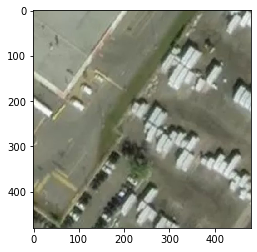

In [18]:
#Quick test
im=Image.open(listPngs[1]).convert('RGB')
plt.imshow(im)
np.array(im).shape

In [19]:
dfGrid=pd.read_csv(pathCsv / "dfGrid.csv")
dfGrid.drop_duplicates(idGrid, inplace=True) #remove duplicate images
print(dfGrid.shape)
dfGrid.head()

(3488, 11)


Group.1   v_CA16_2213  v_CA16_2540    v_CA16_406      gridId    GeoUID  \
0        1  22503.158417    28.333734  12839.862050   1ahuntsic  24660517   
1        2  23329.019053    18.844351   9601.852952   2ahuntsic  24660513   
2       11           NaN          NaN      0.000000  11ahuntsic  24663351   
3       12           NaN          NaN    201.064136  12ahuntsic  24663351   
4       13           NaN          NaN    722.660359  13ahuntsic  24663351   

                 Q_socio                   neighTouching  numberNeigh  \
0  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
1  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
2  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
3  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   
4  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   

   numberDA    rastID  
0       4.0  ahuntsic  
1       5.0  ahuntsic  
2       1.0  ahuntsic  
3       2.0  ahuntsic  
4       2.0  ahuntsic

In [75]:
datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=True)#probabyly no great to have 0 mean since negative values will get mapped back to regular [0,1] range
datagen2 = ImageDataGenerator(samplewise_center=False, samplewise_std_normalization=True)

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [76]:
im=  Image.open( "../../Output/Mapbox/100/Images/4ahuntsic.png")
im2=  Image.open( "../../Output/Mapbox/100/Images/3ahuntsic.png")
imRaw=np.array(im)
imCropped=np.array( im.crop( [300,300,400,400])  )
imCropped2=np.array( im2.crop( [300,300,400,400])  )

arrayBothImages=np.concatenate([np.expand_dims(im,0), np.expand_dims(im2,0)])

Text(0.5, 1.0, 'Raw standardized - std by sample')

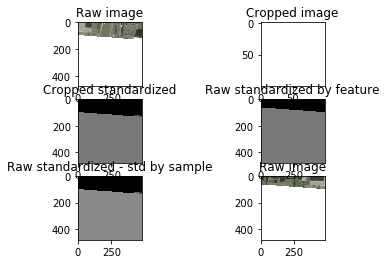

In [77]:
plt.subplot(3,2,1)
plt.imshow(imRaw)
plt.title("Raw image")

plt.subplot(3,2,6)
plt.imshow(im2)
plt.title("Raw image")

plt.subplot(3,2,2)
plt.imshow(imCropped)
plt.title("Cropped image")

plt.subplot(3,2,3)
datagen.fit(arrayBothImages)
iterIm = datagen.flow(arrayBothImages)
imCroppedStd=iterIm.next()[0]
plt.imshow(imCroppedStd)
plt.title("Cropped standardized")

plt.subplot(3,2,4)
datagen.fit(arrayBothImages)
iterIm = datagen.flow(arrayBothImages)
imRawStd=iterIm.next()[0]
plt.imshow(imRawStd)
plt.title("Raw standardized by feature")

plt.subplot(3,2,5)
datagen2.fit(np.expand_dims(imRaw,0))
iterIm = datagen2.flow( np.concatenate([np.expand_dims(im,0), np.expand_dims(im2,0)]) )
imRawStd=iterIm.next()[0]
plt.imshow(imRawStd)
plt.title("Raw standardized - std by sample")

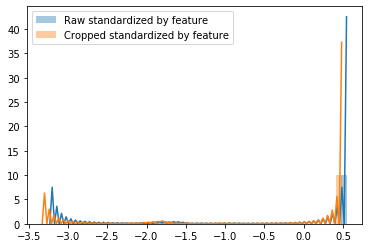

In [78]:
sns.distplot(a=imRawStd.ravel(),label="Raw standardized by feature")
sns.distplot(a=imCroppedStd.ravel(),label="Cropped standardized by feature")
plt.legend()

In [79]:
imTest1=np.zeros((5,5,3))
imTest1[:,4] = 1

imTest2=np.zeros((5,5,3))
imTest2[1,:] = 1

imArr=np.concatenate([np.expand_dims(imTest1,0),np.expand_dims(imTest2,0)])

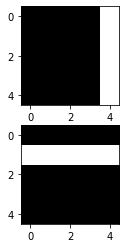

In [80]:
plt.subplot(2,1,1)
plt.imshow(imTest1)

plt.subplot(2,1,2)
plt.imshow(imTest2)

In [81]:
datagen.fit(imArr)
iterFeature= datagen.flow(imArr)

datagen2.fit(imArr)
iterFeature2= datagen2.flow(imArr)

Text(0.5, 1.0, 'by sample - 2')

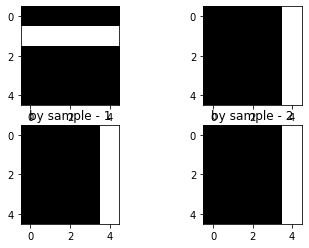

In [82]:
plt.subplot(2,2,1)
plt.imshow(iterFeature.next()[0])

plt.subplot(2,2,2)
plt.imshow(iterFeature.next()[1])

plt.subplot(2,2,3)
plt.imshow(iterFeature2.next()[0])
plt.title("by sample - 1")

plt.subplot(2,2,4)
plt.imshow(iterFeature2.next()[1])
plt.title("by sample - 2")

In [73]:
iterFeature2.next().shape

(2, 5, 5, 3)

In [83]:
iterFeature2.next()[0]

array([[[-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [ 1.999995  ,  1.999995  ,  1.999995  ]],

       [[-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [ 1.999995  ,  1.999995  ,  1.999995  ]],

       [[-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [ 1.999995  ,  1.999995  ,  1.999995  ]],

       [[-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [-0.49999875, -0.49999875, -0.49999875],
        [ 1.999995  ,  1.999995  ,  1.999995  ]],

       [[-0.